# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy as sc
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor

In [5]:
data_train.shape

(14149, 87)

In [6]:
data_test.shape

(5290, 53)

In [7]:
data_full.shape

(19439, 87)

### Проверка эффективности обогащения

In [8]:
def recovery (outp, inp, diff):
    return (outp*(inp-diff))/(inp*(outp-diff))*100

In [9]:
data_train['rougher.output.concentrate_au'].isna().sum()

0

In [10]:
data_train['rougher.input.feed_au'].isna().sum()

0

In [11]:
data_train['rougher.output.tail_ag'].isna().sum()

1

In [12]:
data_train[data_train['rougher.output.tail_ag'].isna()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5471,2017-02-09 19:59:59,8.300065,8.496812,15.253318,42.335997,71.999297,12.764777,3.038042,9.255924,3.458364,...,25.090962,-400.553311,23.032821,-399.929649,22.993873,-449.404418,19.994596,-450.102943,25.010323,-599.840144


In [13]:
mean_absolute_error(
    recovery(data_train[data_train['rougher.output.tail_ag'].index!=5471]\
           ['rougher.output.concentrate_au'],
             data_train[data_train['rougher.output.tail_ag'].index!=5471]\
           ['rougher.input.feed_au'],
             data_train[data_train['rougher.output.tail_ag'].index!=5471]\
           ['rougher.output.tail_au']),
    data_train[data_train['rougher.output.tail_ag'].index!=5471]\
    ['rougher.output.recovery']
)

9.735811566353847e-15

15 знаков после нуля, будем считать что ошибки нет

### Анализ признаков недоступных в тестовой выборке

In [14]:
data_train.drop(data_test.columns, axis=1).columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

В тренировочной выборке отсутствуют:

- расчетные характеристики флотации
- продукт после флотации
- продукт после первой очистки
- продукт после второй очистки
- финальный продукт

Расчетные характеристики флотации и количество продукта на после каждого этапа обработки. По этим данным модели будет проще обучиться, но их не будет при разработке новых месторождений руды.

### Предобработка данных

In [15]:
data_test.isna().sum().max()

25

In [16]:
data_train.isna().sum().max()

1605

In [17]:
data_full.isna().sum().max()

1748

In [18]:
data_full = data_full.ffill()

In [19]:
data_test = data_test.ffill()

In [20]:
data_train = data_train.ffill()

Пропуски заменены ближайшими по дате значениями т.к. соседние по времени параметры часто похожи.

## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

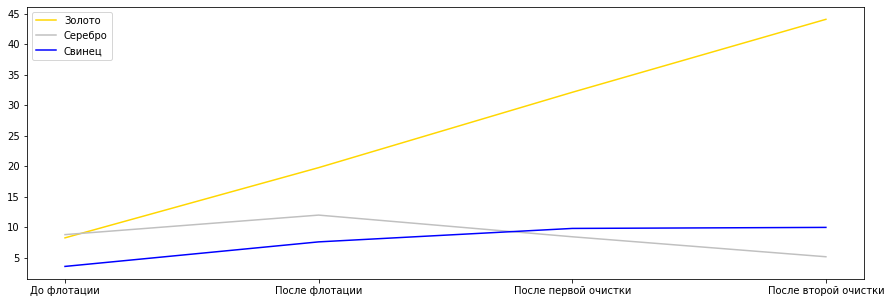

In [21]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,5))
x = ['До флотации', 'После флотации',
      'После первой очистки','После второй очистки']
y = [data_full[x].mean() for x in ['rougher.input.feed_au', 
                                         'rougher.output.concentrate_au',
      'primary_cleaner.output.concentrate_au','final.output.concentrate_au']]
sns.lineplot(x, y ,color='gold',label='Золото')

x = ['До флотации', 'После флотации',
      'После первой очистки','После второй очистки']
y = [data_full[x].mean() for x in ['rougher.input.feed_ag', 
                                         'rougher.output.concentrate_ag',
      'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]
sns.lineplot(x, y ,color='silver',label='Серебро')

x = ['До флотации', 'После флотации',
      'После первой очистки','После второй очистки']
y = [data_full[x].mean() for x in ['rougher.input.feed_pb', 
                                         'rougher.output.concentrate_pb',
      'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]
sns.lineplot(x, y ,color='blue',label='Свинец');

После флотации общая доля всех металлов в концентрате возрастает. 

После первой очистки доля золота и свинца растет, доля серебра уменьшается. 

После второй очистки растет только доля золота. Доля свинца не меняется, доля серебра уменьшается.

### Распределение размеров гранул сырья на обучающей и тестовой выборках

In [22]:
state = np.random.RandomState(12345)
values = []
for i in range(1000):
    test_subsample = data_test['rougher.input.feed_size'].sample(
        n=500, replace=True, random_state=state)
    train_subsample = data_train['rougher.input.feed_size'].sample(
        n=1500, replace=True, random_state=state)
    values.append(sc.stats.ttest_ind(test_subsample, 
                             train_subsample,
                             equal_var=False).pvalue)

alpha = .05
values = pd.Series(values)
for i in range(1,6):
    values_subsample=values.sample(
        n=100, replace=True, random_state=state)
    print(values_subsample.mean())
    if values_subsample.mean()>alpha:
        print('Размеры гранул сырья сильно отличаются')
        print('')
    else:
        print('Размеры гранул сырья не сильно отличаются')
        print('')

0.0014798278819131475
Размеры гранул сырья не сильно отличаются

0.01264468452246764
Размеры гранул сырья не сильно отличаются

0.01277984063624031
Размеры гранул сырья не сильно отличаются

0.011217371815270216
Размеры гранул сырья не сильно отличаются

0.004222812660910318
Размеры гранул сырья не сильно отличаются



### Cуммарная концентрация всех веществ на разных стадиях

#### В сырье

In [23]:
raw_reagent_sum=0
for i in ['rougher.input.feed_ag','rougher.input.feed_pb',
          'rougher.input.feed_sol','rougher.input.feed_au',
          'rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate',
          'rougher.input.floatbank11_sulfate','rougher.input.floatbank11_xanthate'
         ]:
    raw_reagent_sum+= data_full[i].mean()

In [24]:
raw_sum=0
for i in ['rougher.input.feed_ag','rougher.input.feed_pb',
          'rougher.input.feed_sol','rougher.input.feed_au']:
    raw_sum+= data_full[i].mean()

#### В черновом концентрате

In [25]:
rougher_sum=0
for i in ['rougher.output.concentrate_ag','rougher.output.concentrate_pb',
          'rougher.output.concentrate_sol','rougher.output.concentrate_au']:
    rougher_sum+=data_full[i].mean()

#### В финальном концентрате

In [26]:
final_sum=0
for i in ['final.output.concentrate_ag','final.output.concentrate_pb',
          'final.output.concentrate_sol','final.output.concentrate_au']:
    final_sum+=data_full[i].mean()

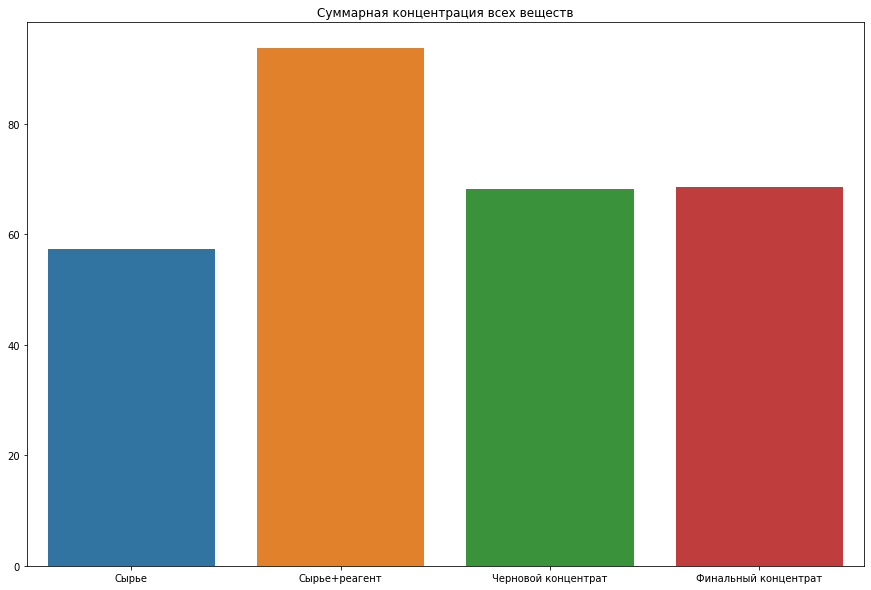

In [27]:
plt.figure(figsize=(15,10))
x = ['Сырье','Сырье+реагент', 'Черновой концентрат',
      'Финальный концентрат']
y = [raw_sum,raw_reagent_sum,rougher_sum,final_sum]
sns.barplot(x, y)
plt.title('Cуммарная концентрация всех веществ');

Суммарная концентрация веществ в черновом концентрате больше, чем в сырье, но в процессе флотации используется много реагента

### Cуммарная концентрация всех веществ на разных стадиях (изменения)

#### В сырье

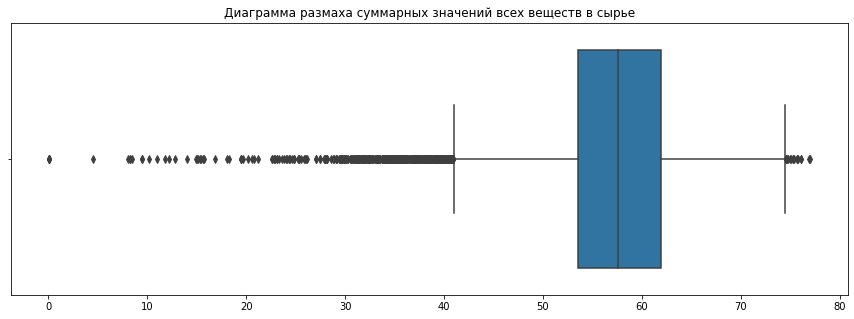

In [28]:
plt.figure(figsize=(15,5))
sns.boxplot(data_full['rougher.input.feed_ag']+data_full['rougher.input.feed_pb']+data_full['rougher.input.feed_sol']\
            +data_full['rougher.input.feed_au'])
plt.title('Диаграмма размаха суммарных значений всех веществ в сырье');

In [29]:
((data_full['rougher.input.feed_ag']+data_full['rougher.input.feed_pb']+data_full['rougher.input.feed_sol']\
+data_full['rougher.input.feed_au'])<30).sum()

93

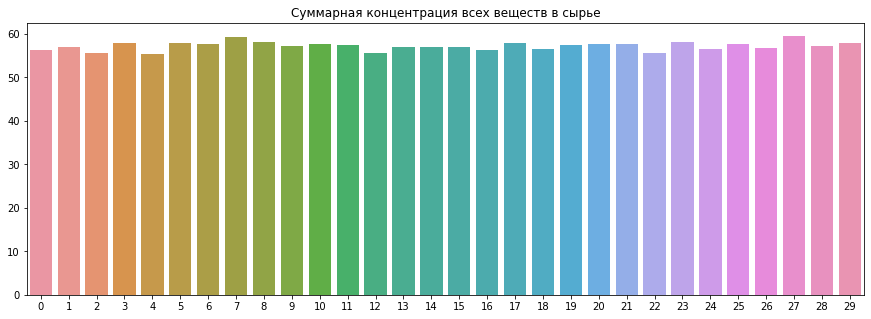

In [30]:
state = np.random.RandomState(12345)
values = []
cols= ['rougher.input.feed_ag','rougher.input.feed_pb',
       'rougher.input.feed_sol','rougher.input.feed_au']
x=[]
for i in range(30):
    x.append(i)
    subsample = data_full[cols].sample(n=50, replace=True, random_state=state)
    sum_values=0
    for j in cols:
        sum_values+=subsample[j].mean()
    values.append(sum_values)
plt.figure(figsize=(15,5))
sns.barplot(x=x,y=values)
plt.title('Cуммарная концентрация всех веществ в сырье');

#### В черновом концентрате

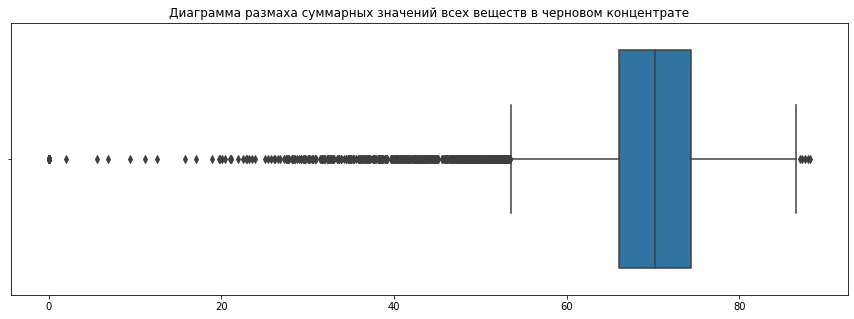

In [31]:
plt.figure(figsize=(15,5))
sns.boxplot(data_full['rougher.output.concentrate_ag']+data_full['rougher.output.concentrate_pb']+\
            data_full['rougher.output.concentrate_sol']+data_full['rougher.output.concentrate_au'])
plt.title('Диаграмма размаха суммарных значений всех веществ в черновом концентрате');

In [32]:
((data_full['rougher.output.concentrate_ag']+data_full['rougher.output.concentrate_pb']+\
data_full['rougher.output.concentrate_sol']+data_full['rougher.output.concentrate_au'])<20).sum()

410

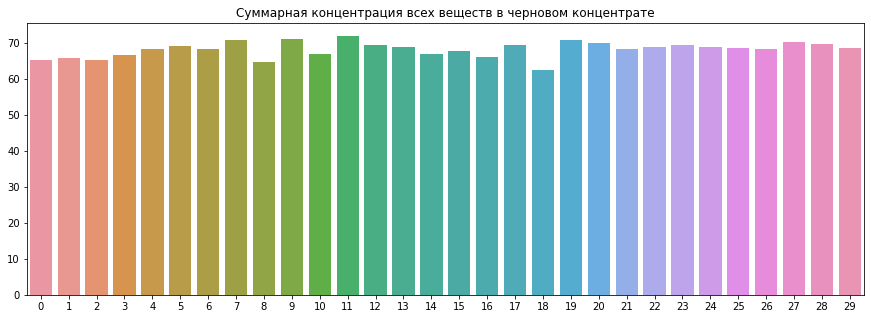

In [33]:
state = np.random.RandomState(12345)
values = []
cols= ['rougher.output.concentrate_ag','rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol','rougher.output.concentrate_au']
x=[]
for i in range(30):
    x.append(i)
    subsample = data_full[cols].sample(n=50, replace=True, random_state=state)
    sum_values=0
    for j in cols:
        sum_values+=subsample[j].mean()
    values.append(sum_values)
plt.figure(figsize=(15,5))
sns.barplot(x=x,y=values)
plt.title('Cуммарная концентрация всех веществ в черновом концентрате');

#### В финальном концентрате

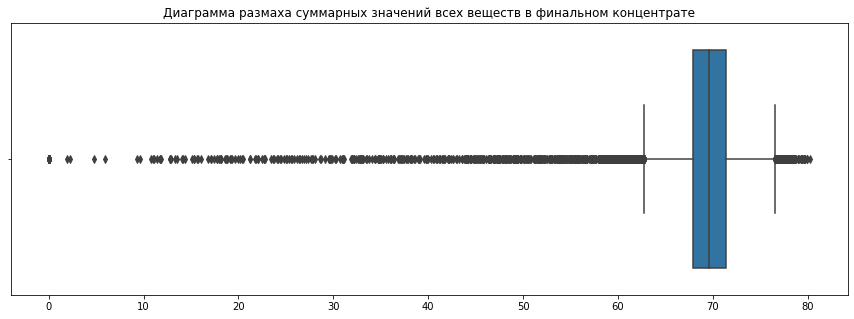

In [34]:
plt.figure(figsize=(15,5))
sns.boxplot(data_full['final.output.concentrate_ag']+data_full['final.output.concentrate_pb']+\
            data_full['final.output.concentrate_sol']+data_full['final.output.concentrate_au'])
plt.title('Диаграмма размаха суммарных значений всех веществ в финальном концентрате');

In [35]:
((data_full['final.output.concentrate_ag']+data_full['final.output.concentrate_pb']+\
data_full['final.output.concentrate_sol']+data_full['final.output.concentrate_au'])<30).sum()

192

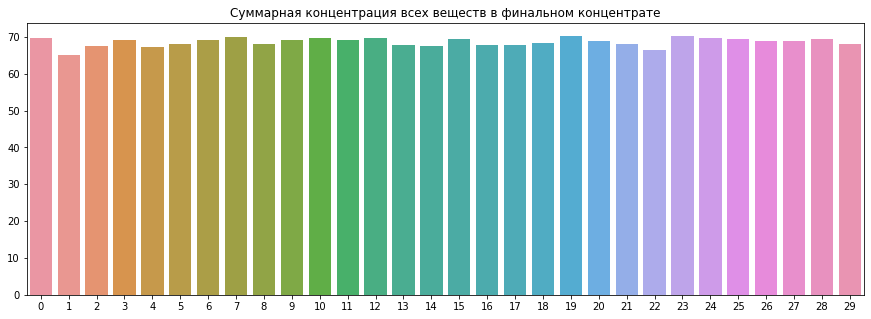

In [36]:
state = np.random.RandomState(12345)
values = []
cols= ['final.output.concentrate_ag','final.output.concentrate_pb',
       'final.output.concentrate_sol','final.output.concentrate_au']
x=[]
for i in range(30):
    x.append(i)
    subsample = data_full[cols].sample(n=50, replace=True, random_state=state)
    sum_values=0
    for j in cols:
        sum_values+=subsample[j].mean()
    values.append(sum_values)
plt.figure(figsize=(15,5))
sns.barplot(x=x,y=values)
plt.title('Cуммарная концентрация всех веществ в финальном концентрате');

В данных имеется незначительное количество выбросов

## Модель

### Функция для вычисления итоговой sMAPE

In [37]:
def sMAPE (target, pred):
    return (abs(target-pred)/((abs(target)+abs(pred))/2)).mean()*100
def final_sMAPE(rough,final):
    return rough/4+3*final/4

### Выбор признаков

In [38]:
features_rough=pd.DataFrame({})
row=0
cols=data_test.columns
for i in cols[1:]:
    features_rough.loc[row,'feature']= i
    features_rough.loc[row,'corr']= data_train[i].corr(
        data_train['rougher.output.recovery'])
    row+=1

In [39]:
features_rough=features_rough[(
    features_rough['corr']>=0.2)]

In [40]:
features_rough

,feature,corr
0,primary_cleaner.input.sulfate,0.272823
19,rougher.input.floatbank10_xanthate,0.238468
21,rougher.input.floatbank11_xanthate,0.216100
42,secondary_cleaner.state.floatbank4_a_air,0.250773
44,secondary_cleaner.state.floatbank4_b_air,0.240501


In [41]:
features_final=pd.DataFrame({})
row=0
cols=data_test.columns
for i in cols[1:]:
    features_final.loc[row,'feature']= i
    features_final.loc[row,'corr']= data_train[i].corr(
        data_train['final.output.recovery'])
    row+=1

In [42]:
features_final=features_final[(
    features_final['corr']>=0.3)]

In [43]:
features_final

,feature,corr
0,primary_cleaner.input.sulfate,0.384798
12,rougher.input.feed_ag,0.310574
17,rougher.input.feed_au,0.308561
19,rougher.input.floatbank10_xanthate,0.328838
21,rougher.input.floatbank11_xanthate,0.305498


### Выборки

In [44]:
rougher_features_train = data_train[features_rough['feature'].to_list()]
final_features_train = data_train[features_final['feature'].to_list()]

rougher_features_test = data_test[features_rough['feature'].to_list()]
final_features_test = data_test[features_final['feature'].to_list()]

rougher_target_train = data_train['rougher.output.recovery']
final_target_train = data_train['final.output.recovery']

rougher_target_test = data_full.query('date in @data_test["date"]')\
['rougher.output.recovery']
final_target_test = data_full.query('date in @data_test["date"]')\
['final.output.recovery']

### Масштабирование

In [45]:
scaler = StandardScaler()

numeric = features_rough['feature'].to_list()
scaler.fit(rougher_features_train[numeric])
rougher_features_train[numeric] = scaler.transform(rougher_features_train[numeric])
rougher_features_test[numeric] = scaler.transform(rougher_features_test[numeric])

numeric = features_final['feature'].to_list()
scaler.fit(final_features_train[numeric])
final_features_train[numeric] = scaler.transform(final_features_train[numeric])
final_features_test[numeric] = scaler.transform(final_features_test[numeric])

### Выбор модели

In [46]:
smape_scorer = make_scorer(sMAPE)

#### DecisionTreeRegressor

In [133]:
best_result = 100
best_depth = 0
result =[]
for depth in range(1,20):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(rougher_features_train,rougher_target_train)
    result = cross_val_score(model, rougher_features_train, rougher_target_train, scoring=smape_scorer)
    if abs(pd.Series(result).mean()) < best_result:
        best_result = pd.Series(result).mean()
        best_depth = depth
                             

print("Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации:",
      best_result,\
      "\n Максимальная глубина:", best_depth)

Оценка DecisionTreeClassifier для предсказания продукта после флотации: 11.038882538643959 
 Максимальная глубина: 3


In [136]:
best_result = 100
best_depth = 0
result =[]
for depth in range(1,20):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(final_features_train,final_target_train)
    result = cross_val_score(model, final_features_train, final_target_train, scoring=smape_scorer) 
    if abs(pd.Series(result).mean()) < best_result:
        best_result = pd.Series(result).mean()
        best_depth = depth
                             

print("Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта:",
      best_result,\
      "\n Максимальная глубина:", best_depth)

Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта: 10.48806488415443 
 Максимальная глубина: 4


#### RandomForestRegressor

In [137]:
best_result = 100
best_depth = 0
best_est = 0
result =[]
for est in range(1,31,10):
    for depth in range(1,41,3):
        model = RandomForestRegressor(random_state=12345, max_depth=depth,
                                      n_estimators=est)
        model.fit(rougher_features_train,rougher_target_train)
        result = cross_val_score(model,rougher_features_train,rougher_target_train, scoring=smape_scorer)
        if abs(pd.Series(result).mean()) < best_result:
            best_result = pd.Series(result).mean()
            best_depth = depth
            best_est = est
            
print("Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации:",
      best_result,\
      "\n Максимальная глубина:", best_depth, 'Количество деревьев', best_est)

Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации: 10.86618230394103 
 Максимальная глубина: 7 Количество деревьев 21


In [138]:
best_result = 100
best_depth = 0
best_est = 0
result =[]
for est in range(1,51,10):
    for depth in range(1,20,3):
        model = RandomForestRegressor(random_state=12345, max_depth=depth,
                                      n_estimators=est)
        model.fit(final_features_train,final_target_train)
        result = cross_val_score(model,final_features_train,final_target_train, scoring=smape_scorer) 
        if abs(pd.Series(result).mean()) < best_result:
            best_result = pd.Series(result).mean()
            best_depth = depth
            best_est = est
            
print("Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта:",
      best_result,\
      "\n Максимальная глубина:", best_depth, 'Количество деревьев', best_est)

Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта: 10.245727148181833 
 Максимальная глубина: 4 Количество деревьев 41


#### LinearRegression

In [139]:
model = LinearRegression()
model.fit(rougher_features_train,rougher_target_train)
result = cross_val_score(model,rougher_features_train,rougher_target_train, scoring=smape_scorer)
print("Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации:",
      pd.Series(result).mean())

Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации: 10.771614594539974


In [140]:
model = LinearRegression()
model.fit(final_features_train,final_target_train)
result = cross_val_score(model,final_features_train,final_target_train, scoring=smape_scorer)
print("Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта:",
      pd.Series(result).mean())

Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта: 10.185132134457362


#### Константная модель

In [52]:
dummy_model_rougher = DummyRegressor(strategy='constant',constant=data_full['rougher.output.recovery'].mean())
dummy_model_rougher.fit(rougher_features_train, rougher_target_train)
result = cross_val_score(dummy_model_rougher,rougher_features_train,rougher_target_train, scoring=smape_scorer)
print("Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта:",
      pd.Series(result).mean())

Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта: 10.379799283438492


In [53]:
dummy_model_final = DummyRegressor(strategy='constant',constant=data_full['final.output.recovery'].mean())
dummy_model_final.fit(final_features_train, final_target_train)
result = cross_val_score(dummy_model_final,final_features_train,final_target_train, scoring=smape_scorer)
print("Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта:",
      pd.Series(result).mean())

Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта: 10.25957407354855


Лучшая модель для предсказания продукта после флотации и финального продукта: LinearRegression

### Модель на тестовой выборке

In [47]:
model = LinearRegression()
model.fit(rougher_features_train,rougher_target_train)
rougher_pred = model.predict(rougher_features_test)
result = sMAPE(rougher_target_test, rougher_pred)
print("Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации:",
      pd.Series(result).mean())

Cимметричное среднее абсолютное процентное отклонение для предсказания продукта после флотации: 8.555286833166214


In [48]:
model = LinearRegression()
model.fit(final_features_train,final_target_train)
final_pred = model.predict(final_features_test)
result = sMAPE(final_target_test, final_pred)
print("Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта:",
      pd.Series(result).mean())

Cимметричное среднее абсолютное процентное отклонение для предсказания финального продукта: 9.54399582939016


In [49]:
print('sMAPE константной модели для продукта флотации на тестовой выборке:'
     ,sMAPE(rougher_target_test,data_full['rougher.output.recovery'].mean()))
print('sMAPE константной модели для финального продукта на тестовой выборке:'
     ,sMAPE(final_target_test,data_full['final.output.recovery'].mean()))

sMAPE константной модели для продукта флотации на тестовой выборке: 9.885165061706179
sMAPE константной модели для финального продукта на тестовой выборке: 9.954530653964758


### Итоговое sMAPE

In [54]:
final_sMAPE(sMAPE(rougher_target_test, rougher_pred),
            sMAPE(final_target_test, final_pred))

9.296818580334174

In [55]:
final_sMAPE(sMAPE(rougher_target_test, data_full['rougher.output.recovery'].mean()),
            sMAPE(final_target_test, data_full['final.output.recovery'].mean()))

9.937189255900112

Итоговое симметричное среднее абсолютное процентное отклонение модели LinearRegression: 9.3%

Константная модель: 9.94%

### Вывод

После флотации общая доля всех металлов в концентрате возрастает.

После первой очистки доля золота и свинца растет, доля серебра уменьшается.

После второй очистки растет только доля золота. Доля свинца не меняется, доля серебра уменьшается.

Размеры гранул сырья равно распределен по выборкам

В данных имеется незначительное количество выбросов

Наибольшую корреляцию с продуктом флотации и финальным продуктом имеет показатель сульфида натрия при первичной очистке

Лучшая модель для предсказания продукта после флотации и финального продукта: LinearRegression

Пусть и не намного, но LinearRegression справляется лучше, чем константная модель - разница в итоговом sMAPE: 0.64%